In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pycountry

In [2]:
tickets_df = pd.read_json("tickets.json")
tickets_df.head()

,value,trip_class,origin,number_of_changes,found_at,destination,depart_date,airline,search_date
0,43270,0,MOW,2.0,2022-03-30 14:54:04,SYZ,2022-04-21,TK,2022-04-02
1,28166,0,MOW,3.0,2022-04-02 08:08:06,SPU,2022-04-25,W6,2022-04-02
2,24159,0,MOW,2.0,2022-04-01 09:23:26,SZF,2022-04-14,TK,2022-04-02
3,11160,0,MOW,1.0,2022-04-02 12:09:50,ABA,2022-04-12,S7,2022-04-02
4,19920,0,MOW,1.0,2022-04-02 12:44:34,CAI,2022-04-14,SU,2022-04-02


In [3]:
tickets_df.isnull().sum()

value                    0
trip_class               0
origin                   0
number_of_changes    18148
found_at                 0
destination              0
depart_date              0
airline                  0
search_date              0
dtype: int64

In [4]:
tickets_df.fillna({"number_of_changes" : 0}, inplace=True)
tickets_df.isnull().sum().sum()

0

In [5]:
tickets_df.nunique()

value                29315
trip_class               1
origin                   5
number_of_changes        7
found_at             60263
destination           1276
depart_date            327
airline                173
search_date             11
dtype: int64

In [6]:
# delete not-used features
tickets_df.drop(columns=["trip_class", "search_date"], inplace=True)

In [7]:
tickets_df.rename(columns={"value" : "price", 
                           "origin" : "origin_city_code", 
                           "destination" : "destination_airport_code", 
                           "airline" : "airline_code", 
                           "found_at" : "search_date"}, 
                  inplace=True)

In [8]:
# convert date strings to date type
tickets_df["search_date"] = pd.to_datetime(tickets_df["search_date"].dt.date)
tickets_df["depart_date"] = pd.to_datetime(tickets_df["depart_date"])

tickets_df["diff_days"] = (tickets_df["depart_date"] - tickets_df["search_date"]).dt.days

tickets_df["search_weekday"] = tickets_df["search_date"].dt.weekday
tickets_df["depart_weekday"] = tickets_df["depart_date"].dt.weekday

In [9]:
tickets_df[tickets_df["diff_days"] < 0].count().sum()

0

In [10]:
# convert to int type
tickets_df["number_of_changes"] = tickets_df["number_of_changes"].astype("int8")

In [11]:
tickets_df.head()

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,airline_code,diff_days,search_weekday,depart_weekday
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,TK,22,2,3
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,W6,23,5,0
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,TK,13,4,3
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,S7,10,5,1
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,SU,12,5,3


In [12]:
for dt_col in ["depart_date","search_date"]:
    prefix = dt_col.split("_date")[0]
    s_date = tickets_df[dt_col]
    
    tickets_df[f"{prefix}_month"] = s_date.dt.month
    tickets_df[f"{prefix}_weekday"] = s_date.dt.weekday
    tickets_df[f"{prefix}_day"] = s_date.dt.day

tickets_df.head()

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,airline_code,diff_days,search_weekday,depart_weekday,depart_month,depart_day,search_month,search_day
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,TK,22,2,3,4,21,3,30
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,W6,23,5,0,4,25,4,2
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,TK,13,4,3,4,14,4,1
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,S7,10,5,1,4,12,4,2
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,SU,12,5,3,4,14,4,2


In [13]:
# import information about airports
airports_df = pd.read_json("airports.json")
airports_df.head()

,city_code,country_code,name_translations,time_zone,flightable,coordinates,name,code,iata_type
0,PIT,US,{'en': 'Pittsburgh International Airport'},America/New_York,True,"{'lat': 40.49585, 'lon': -80.25657}",Питтсбург Интернэшинл,PIT,airport
1,GAL,US,{'en': 'Edward G. Pitka Sr. Airport'},America/Anchorage,True,"{'lat': 64.73798, 'lon': -156.94186}",Галена,GAL,airport
2,YAG,CA,{'en': 'Fort Frances Municipal Airport'},America/Winnipeg,True,"{'lat': 48.65278, 'lon': -93.44722}",Форт-Франсес,YAG,airport
3,ILD,ES,{'en': 'Lleida Railway Station'},Europe/Madrid,True,"{'lat': 41.61667, 'lon': 0.6333300000000001}",Льейда (жд вокзал),QLQ,railway
4,SVX,RU,{'en': 'Koltsovo International Airport'},Asia/Yekaterinburg,True,"{'lat': 56.750336, 'lon': 60.804314}",Кольцово,SVX,airport


In [14]:
airports_df["flightable"].nunique()

1

In [15]:
# Feature is useless
airports_df.drop(columns=["flightable"], inplace=True)

In [16]:
airports_df[["name_translations", "name"]].isnull().sum()

name_translations      0
name                 157
dtype: int64

In [17]:
airports_df["airport_name"] = list(map(lambda item: item["en"], airports_df["name_translations"]))
airports_df.drop(columns=["name_translations", "name"], inplace=True)

airports_df.rename(columns={"code" : "airport_code"}, inplace=True)

# parse latitudes and longs
lats, lons = [], []
for coord in airports_df["coordinates"]:
    lats.append(coord["lat"])
    lons.append(coord["lon"])

airports_df["latitude"] = lats
airports_df["longitude"] = lons
airports_df.drop(columns=["coordinates"], inplace=True)
airports_df.head()

,city_code,country_code,time_zone,airport_code,iata_type,airport_name,latitude,longitude
0,PIT,US,America/New_York,PIT,airport,Pittsburgh International Airport,40.495850,-80.256570
1,GAL,US,America/Anchorage,GAL,airport,Edward G. Pitka Sr. Airport,64.737980,-156.941860
2,YAG,CA,America/Winnipeg,YAG,airport,Fort Frances Municipal Airport,48.652780,-93.447220
3,ILD,ES,Europe/Madrid,QLQ,railway,Lleida Railway Station,41.616670,0.633330
4,SVX,RU,Asia/Yekaterinburg,SVX,airport,Koltsovo International Airport,56.750336,60.804314


In [18]:
col_group, col_meas = ["city_code", "iata_type"], ["airport_code"]
col_all = col_group + col_meas
airports_df[col_all].groupby(by=col_group).count().sort_values(by=col_meas, ascending=False)

airport_code
city_code iata_type              
LON       railway               9
          airport               6
CHI       airport               5
SAC       airport               4
DFW       airport               4
...                           ...
HVG       airport               1
HVN       airport               1
          railway               1
HVR       airport               1
ИФА       airport               1

[3353 rows x 1 columns]

In [19]:
tickets_df[["origin_city_code", "destination_airport_code"]]

,origin_city_code,destination_airport_code
0,MOW,SYZ
1,MOW,SPU
2,MOW,SZF
3,MOW,ABA
4,MOW,CAI
...,...,...
106343,MOW,KHV
106344,MOW,HKG
106345,MOW,PQC
106346,MOW,EVN


In [20]:
tickets_df.shape

(106348, 14)

In [21]:
airports_df[["city_code", "airport_code", "latitude", "longitude"]].groupby("city_code").mean(["latitude", "longitide"])

,latitude,longitude
city_code,,
,60.728889,96.443333
AAE,36.821392,7.811857
AAH,50.775440,6.081510
AAL,57.057681,9.895006
AAN,24.233866,55.680673
...,...,...
ZYK,22.468485,113.913650
ZYL,24.957598,91.870476
ZZO,50.666668,142.750000


In [22]:
pd.merge(left=tickets_df[["origin_city_code", "destination_airport_code"]],
         right=airports_df[["city_code", "airport_code", "latitude", "longitude"]].groupby("city_code").mean(["latitude", "longitide"]),
         left_on="origin_city_code",
         right_on="city_code",
         how="left")

,origin_city_code,destination_airport_code,latitude,longitude
0,MOW,SYZ,55.70184,37.648892
1,MOW,SPU,55.70184,37.648892
2,MOW,SZF,55.70184,37.648892
3,MOW,ABA,55.70184,37.648892
4,MOW,CAI,55.70184,37.648892
...,...,...,...,...
106343,MOW,KHV,55.70184,37.648892
106344,MOW,HKG,55.70184,37.648892
106345,MOW,PQC,55.70184,37.648892
106346,MOW,EVN,55.70184,37.648892


In [23]:
tmp_df = pd.merge(left=tickets_df[["origin_city_code", "destination_airport_code"]],
                  right=airports_df[["city_code", "airport_code", "latitude", "longitude"]].groupby("city_code").mean(["latitude", "longitide"]),
                  left_on="origin_city_code",
                  right_on="city_code",
                  how="left")

tmp_df.rename(columns={"latitude" : "origin_latitude",
                       "longitude" : "origin_longitude"}, inplace=True)


tmp_df = pd.merge(left=tmp_df,
                  right=airports_df[["city_code", "airport_code", "latitude", "longitude"]], 
                  left_on="destination_airport_code", 
                  right_on="airport_code",
                  how="left")

tmp_df.rename(columns={"latitude" : "destination_latitude",
                       "longitude" : "destination_longitude"}, inplace=True)

tmp_df.drop(columns=[
    "airport_code", 
    "city_code", 
    ], inplace=True)

tmp_df

,origin_city_code,destination_airport_code,origin_latitude,origin_longitude,destination_latitude,destination_longitude
0,MOW,SYZ,55.70184,37.648892,29.546130,52.589970
1,MOW,SPU,55.70184,37.648892,43.536526,16.299460
2,MOW,SZF,55.70184,37.648892,41.257380,36.555058
3,MOW,ABA,55.70184,37.648892,53.716667,91.500000
4,MOW,CAI,55.70184,37.648892,30.120106,31.406470
...,...,...,...,...,...,...
106343,MOW,KHV,55.70184,37.648892,48.524563,135.168610
106344,MOW,HKG,55.70184,37.648892,22.315248,113.936490
106345,MOW,PQC,55.70184,37.648892,10.223722,103.963240
106346,MOW,EVN,55.70184,37.648892,40.152720,44.398050


In [24]:
tmp_df.shape[0] == tickets_df.shape[0]

True

In [25]:
# function calculated dictance in km between 2 cities
def calculate_distance(df, origin_coordinates, destination_coordinates):
    lat1, lon1 = map(np.radians, df[origin_coordinates].T.values)
    lat2, lon2 = map(np.radians, df[destination_coordinates].T.values)

    x = np.subtract(lat1, lat2)
    y = np.subtract(lon1, lon2)
    
    z = np.sin(x / 2)**2 + np.cos(lat1) * np.cos(lat2) *  np.sin(y / 2)**2
    dist = 6373.0 * (2 * np.arctan2(np.sqrt(z), np.sqrt(1 - z)))
    
    return np.round(dist, 2)

In [26]:
calculate_distance(tmp_df, 
                   origin_coordinates=["origin_latitude", "origin_longitude"],
                   destination_coordinates=["destination_latitude", "destination_longitude"])

array([3140.42, 2033.76, 1608.63, ..., 7599.35, 1799.12, 6781.36])

In [27]:
tickets_df["distance"] = calculate_distance(tmp_df,
                                            origin_coordinates=["origin_latitude", "origin_longitude"],
                                            destination_coordinates=["destination_latitude", "destination_longitude"])
tickets_df

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,airline_code,diff_days,search_weekday,depart_weekday,depart_month,depart_day,search_month,search_day,distance
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,TK,22,2,3,4,21,3,30,3140.42
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,W6,23,5,0,4,25,4,2,2033.76
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,TK,13,4,3,4,14,4,1,1608.63
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,S7,10,5,1,4,12,4,2,3379.79
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,SU,12,5,3,4,14,4,2,2887.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106343,13133,MOW,1,2022-02-09,KHV,2022-12-09,S7,303,2,4,12,9,2,9,6144.50
106344,23341,MOW,1,2022-02-08,HKG,2022-12-28,TK,323,1,2,12,28,2,8,7126.65
106345,44964,MOW,3,2022-02-04,PQC,2022-12-28,QR,327,4,2,12,28,2,4,7599.35
106346,5830,MOW,0,2022-02-09,EVN,2022-12-06,S7,300,2,1,12,6,2,9,1799.12


In [28]:
# import information about Airlines
airlines_df = pd.read_json("airlines.json")
airlines_df

,name,code,name_translations
0,None,DN,{'en': 'Norwegian Air'}
1,None,AI,{'en': 'Air India'}
2,None,V1,"{'en': 'IBS Software Services Americas, Inc.'}"
3,None,DE,{'en': 'Condor'}
4,Аврора,HZ,{'en': 'Aurora'}
...,...,...,...
1062,None,HX,{'en': 'Hong Kong Airlines'}
1063,None,N7,{'en': 'Nordic Regional Airline'}
1064,None,B6,{'en': 'JetBlue Airways'}
1065,Air Iceland,NY,{'en': 'Air Iceland'}


In [29]:
airlines_df["name"] = list(map(lambda item: item["en"], airlines_df["name_translations"]))
airlines_df.drop(columns=["name_translations"], inplace=True)
airlines_df = airlines_df[["code", "name"]]
airlines_df.rename(columns={"code": "airline_code", "name": "airline_name"}, inplace=True)
airlines_df

,airline_code,airline_name
0,DN,Norwegian Air
1,AI,Air India
2,V1,"IBS Software Services Americas, Inc."
3,DE,Condor
4,HZ,Aurora
...,...,...
1062,HX,Hong Kong Airlines
1063,N7,Nordic Regional Airline
1064,B6,JetBlue Airways
1065,NY,Air Iceland


In [30]:
airlines_df[["airline_code", "airline_name"]].nunique()

airline_code    1067
airline_name    1043
dtype: int64

In [31]:
counts = airlines_df.airline_name.value_counts()
airlines_df[airlines_df.airline_name.isin(counts.index[counts.gt(1)])].sort_values("airline_name")

,airline_code,airline_name
427,I9,Air Italy
608,IG,Air Italy
705,P2,Airkenya Express
639,QP,Airkenya Express
69,Z7,Amaszonas
339,Z8,Amaszonas
1019,ТФ,Avia Traffic Company
125,YK,Avia Traffic Company
782,3R,Avior Airlines
493,9V,Avior Airlines


In [32]:
airports_df

,city_code,country_code,time_zone,airport_code,iata_type,airport_name,latitude,longitude
0,PIT,US,America/New_York,PIT,airport,Pittsburgh International Airport,40.495850,-80.256570
1,GAL,US,America/Anchorage,GAL,airport,Edward G. Pitka Sr. Airport,64.737980,-156.941860
2,YAG,CA,America/Winnipeg,YAG,airport,Fort Frances Municipal Airport,48.652780,-93.447220
3,ILD,ES,Europe/Madrid,QLQ,railway,Lleida Railway Station,41.616670,0.633330
4,SVX,RU,Asia/Yekaterinburg,SVX,airport,Koltsovo International Airport,56.750336,60.804314
...,...,...,...,...,...,...,...,...
3542,JPA,BR,America/Fortaleza,JPA,airport,Presidente Castro Pinto International Airport,-7.145357,-34.948160
3543,MOL,NO,Europe/Oslo,MOL,airport,"Molde Airport, Aro",62.747303,7.262118
3544,,RU,,КЯС,airline,Cheremshanka,56.176666,92.543335
3545,,RU,,ТАУ,airline,Gornyj,64.333336,100.433334


In [33]:
df = pd.merge(left=tickets_df,
              right=airlines_df,
              left_on="airline_code",
              right_on="airline_code",
              how="inner")

df = pd.merge(left=df, 
              right=airports_df[["airport_code", "city_code", "country_code", "time_zone", "iata_type", "airport_name"]], 
              left_on="destination_airport_code",
              right_on="airport_code",
              how="inner")

df

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,airline_code,diff_days,search_weekday,depart_weekday,...,search_month,search_day,distance,airline_name,airport_code,city_code,country_code,time_zone,iata_type,airport_name
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,TK,22,2,3,...,3,30,3140.42,Turkish Airlines,SYZ,SYZ,IR,Asia/Tehran,airport,Shiraz International Airport
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,W6,23,5,0,...,4,2,2033.76,Wizz Air,SPU,SPU,HR,Europe/Zagreb,airport,Split Airport
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,TK,13,4,3,...,4,1,1608.63,Turkish Airlines,SZF,SZF,TR,Europe/Istanbul,airport,Samsun-Carsamba Airport
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,S7,10,5,1,...,4,2,3379.79,S7 Airlines,ABA,ABA,RU,Asia/Krasnoyarsk,airport,Abakan Airport
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,SU,12,5,3,...,4,2,2887.81,Aeroflot,CAI,CAI,EG,Africa/Cairo,airport,Cairo International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97854,13133,MOW,1,2022-02-09,KHV,2022-12-09,S7,303,2,4,...,2,9,6144.50,S7 Airlines,KHV,KHV,RU,Asia/Vladivostok,airport,Khabarovsk Airport
97855,23341,MOW,1,2022-02-08,HKG,2022-12-28,TK,323,1,2,...,2,8,7126.65,Turkish Airlines,HKG,HKG,HK,Asia/Hong_Kong,airport,Hong Kong International Airport
97856,44964,MOW,3,2022-02-04,PQC,2022-12-28,QR,327,4,2,...,2,4,7599.35,Qatar Airways,PQC,PQC,VN,Asia/Ho_Chi_Minh,airport,Phu Quoc Airport
97857,5830,MOW,0,2022-02-09,EVN,2022-12-06,S7,300,2,1,...,2,9,1799.12,S7 Airlines,EVN,EVN,AM,Asia/Yerevan,airport,Zvartnots International Airport


In [34]:
df.rename(columns={"airport_name" : "destination_airport_name",
                   "city_code" : "destination_city_code",
                   "country_code" : "destination_country_code"}, inplace=True)

df

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,airline_code,diff_days,search_weekday,depart_weekday,...,search_month,search_day,distance,airline_name,airport_code,destination_city_code,destination_country_code,time_zone,iata_type,destination_airport_name
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,TK,22,2,3,...,3,30,3140.42,Turkish Airlines,SYZ,SYZ,IR,Asia/Tehran,airport,Shiraz International Airport
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,W6,23,5,0,...,4,2,2033.76,Wizz Air,SPU,SPU,HR,Europe/Zagreb,airport,Split Airport
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,TK,13,4,3,...,4,1,1608.63,Turkish Airlines,SZF,SZF,TR,Europe/Istanbul,airport,Samsun-Carsamba Airport
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,S7,10,5,1,...,4,2,3379.79,S7 Airlines,ABA,ABA,RU,Asia/Krasnoyarsk,airport,Abakan Airport
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,SU,12,5,3,...,4,2,2887.81,Aeroflot,CAI,CAI,EG,Africa/Cairo,airport,Cairo International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97854,13133,MOW,1,2022-02-09,KHV,2022-12-09,S7,303,2,4,...,2,9,6144.50,S7 Airlines,KHV,KHV,RU,Asia/Vladivostok,airport,Khabarovsk Airport
97855,23341,MOW,1,2022-02-08,HKG,2022-12-28,TK,323,1,2,...,2,8,7126.65,Turkish Airlines,HKG,HKG,HK,Asia/Hong_Kong,airport,Hong Kong International Airport
97856,44964,MOW,3,2022-02-04,PQC,2022-12-28,QR,327,4,2,...,2,4,7599.35,Qatar Airways,PQC,PQC,VN,Asia/Ho_Chi_Minh,airport,Phu Quoc Airport
97857,5830,MOW,0,2022-02-09,EVN,2022-12-06,S7,300,2,1,...,2,9,1799.12,S7 Airlines,EVN,EVN,AM,Asia/Yerevan,airport,Zvartnots International Airport


In [35]:
df[["airline_code", "airline_name"]].nunique()

airline_code    160
airline_name    156
dtype: int64

In [36]:
df.drop(columns=["airline_code"], inplace=True)
df.rename(columns={"airline_name" : "airline"}, inplace=True)
df

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,diff_days,search_weekday,depart_weekday,depart_month,...,search_month,search_day,distance,airline,airport_code,destination_city_code,destination_country_code,time_zone,iata_type,destination_airport_name
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,22,2,3,4,...,3,30,3140.42,Turkish Airlines,SYZ,SYZ,IR,Asia/Tehran,airport,Shiraz International Airport
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,23,5,0,4,...,4,2,2033.76,Wizz Air,SPU,SPU,HR,Europe/Zagreb,airport,Split Airport
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,13,4,3,4,...,4,1,1608.63,Turkish Airlines,SZF,SZF,TR,Europe/Istanbul,airport,Samsun-Carsamba Airport
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,10,5,1,4,...,4,2,3379.79,S7 Airlines,ABA,ABA,RU,Asia/Krasnoyarsk,airport,Abakan Airport
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,12,5,3,4,...,4,2,2887.81,Aeroflot,CAI,CAI,EG,Africa/Cairo,airport,Cairo International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97854,13133,MOW,1,2022-02-09,KHV,2022-12-09,303,2,4,12,...,2,9,6144.50,S7 Airlines,KHV,KHV,RU,Asia/Vladivostok,airport,Khabarovsk Airport
97855,23341,MOW,1,2022-02-08,HKG,2022-12-28,323,1,2,12,...,2,8,7126.65,Turkish Airlines,HKG,HKG,HK,Asia/Hong_Kong,airport,Hong Kong International Airport
97856,44964,MOW,3,2022-02-04,PQC,2022-12-28,327,4,2,12,...,2,4,7599.35,Qatar Airways,PQC,PQC,VN,Asia/Ho_Chi_Minh,airport,Phu Quoc Airport
97857,5830,MOW,0,2022-02-09,EVN,2022-12-06,300,2,1,12,...,2,9,1799.12,S7 Airlines,EVN,EVN,AM,Asia/Yerevan,airport,Zvartnots International Airport


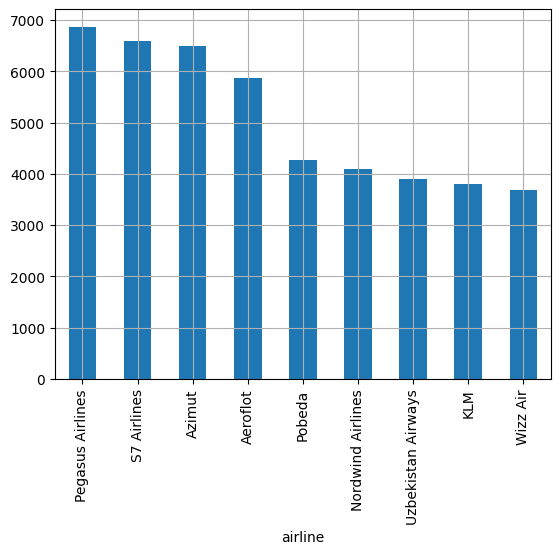

In [37]:
number_of_airlines = 10
ax = df.airline.value_counts()[1:number_of_airlines].plot.bar(log=False, rot = 90, grid=True)

In [38]:
airlines = df.airline.value_counts()[:number_of_airlines]
airline_mask = df.airline.isin(airlines.index)
df = df[airline_mask]
df["airline"].nunique()

10

In [39]:
df.isnull().sum()

price                       0
origin_city_code            0
number_of_changes           0
search_date                 0
destination_airport_code    0
depart_date                 0
diff_days                   0
search_weekday              0
depart_weekday              0
depart_month                0
depart_day                  0
search_month                0
search_day                  0
distance                    0
airline                     0
airport_code                0
destination_city_code       0
destination_country_code    0
time_zone                   0
iata_type                   0
destination_airport_name    0
dtype: int64

In [40]:
df.isna().sum()

price                       0
origin_city_code            0
number_of_changes           0
search_date                 0
destination_airport_code    0
depart_date                 0
diff_days                   0
search_weekday              0
depart_weekday              0
depart_month                0
depart_day                  0
search_month                0
search_day                  0
distance                    0
airline                     0
airport_code                0
destination_city_code       0
destination_country_code    0
time_zone                   0
iata_type                   0
destination_airport_name    0
dtype: int64

In [41]:
df[df["destination_city_code"] == ""]

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,diff_days,search_weekday,depart_weekday,depart_month,...,search_month,search_day,distance,airline,airport_code,destination_city_code,destination_country_code,time_zone,iata_type,destination_airport_name
331,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
8348,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
20857,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
28933,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
32602,29165,LED,1,2022-04-07,ТАУ,2022-04-28,21,3,3,4,...,4,7,3490.76,Aeroflot,ТАУ,,RU,,airline,Gornyj
40302,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
43983,29165,LED,1,2022-04-07,ТАУ,2022-04-28,21,3,3,4,...,4,7,3490.76,Aeroflot,ТАУ,,RU,,airline,Gornyj
51733,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
59923,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
71048,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj


In [42]:
df[["destination_airport_code", "destination_city_code", "destination_country_code"]].nunique()

destination_airport_code    967
destination_city_code       967
destination_country_code    173
dtype: int64

In [43]:
df[df["destination_airport_code"] != df["destination_city_code"]]

,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,diff_days,search_weekday,depart_weekday,depart_month,...,search_month,search_day,distance,airline,airport_code,destination_city_code,destination_country_code,time_zone,iata_type,destination_airport_name
331,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
8348,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
20857,24555,MOW,1,2022-03-30,ТАУ,2022-04-05,6,2,1,4,...,3,30,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
28933,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
32602,29165,LED,1,2022-04-07,ТАУ,2022-04-28,21,3,3,4,...,4,7,3490.76,Aeroflot,ТАУ,,RU,,airline,Gornyj
40302,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
43983,29165,LED,1,2022-04-07,ТАУ,2022-04-28,21,3,3,4,...,4,7,3490.76,Aeroflot,ТАУ,,RU,,airline,Gornyj
51733,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
59923,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj
71048,24510,MOW,1,2022-04-04,ТАУ,2022-04-15,11,0,4,4,...,4,4,3459.75,Aeroflot,ТАУ,,RU,,airline,Gornyj


In [44]:
df.drop(columns=["destination_city_code"], inplace=True)
df

C:\Users\egora\AppData\Local\Temp\ipykernel_13396\1546282191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["destination_city_code"], inplace=True)


,price,origin_city_code,number_of_changes,search_date,destination_airport_code,depart_date,diff_days,search_weekday,depart_weekday,depart_month,depart_day,search_month,search_day,distance,airline,airport_code,destination_country_code,time_zone,iata_type,destination_airport_name
0,43270,MOW,2,2022-03-30,SYZ,2022-04-21,22,2,3,4,21,3,30,3140.42,Turkish Airlines,SYZ,IR,Asia/Tehran,airport,Shiraz International Airport
1,28166,MOW,3,2022-04-02,SPU,2022-04-25,23,5,0,4,25,4,2,2033.76,Wizz Air,SPU,HR,Europe/Zagreb,airport,Split Airport
2,24159,MOW,2,2022-04-01,SZF,2022-04-14,13,4,3,4,14,4,1,1608.63,Turkish Airlines,SZF,TR,Europe/Istanbul,airport,Samsun-Carsamba Airport
3,11160,MOW,1,2022-04-02,ABA,2022-04-12,10,5,1,4,12,4,2,3379.79,S7 Airlines,ABA,RU,Asia/Krasnoyarsk,airport,Abakan Airport
4,19920,MOW,1,2022-04-02,CAI,2022-04-14,12,5,3,4,14,4,2,2887.81,Aeroflot,CAI,EG,Africa/Cairo,airport,Cairo International Airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97852,20081,MOW,1,2022-02-09,DYU,2022-12-06,300,2,1,12,6,2,9,2990.55,Turkish Airlines,DYU,TJ,Asia/Dushanbe,airport,Dushanbe Airport
97854,13133,MOW,1,2022-02-09,KHV,2022-12-09,303,2,4,12,9,2,9,6144.50,S7 Airlines,KHV,RU,Asia/Vladivostok,airport,Khabarovsk Airport
97855,23341,MOW,1,2022-02-08,HKG,2022-12-28,323,1,2,12,28,2,8,7126.65,Turkish Airlines,HKG,HK,Asia/Hong_Kong,airport,Hong Kong International Airport
97857,5830,MOW,0,2022-02-09,EVN,2022-12-06,300,2,1,12,6,2,9,1799.12,S7 Airlines,EVN,AM,Asia/Yerevan,airport,Zvartnots International Airport


In [45]:
df[["destination_airport_code", "destination_country_code"]].nunique()

destination_airport_code    967
destination_country_code    173
dtype: int64

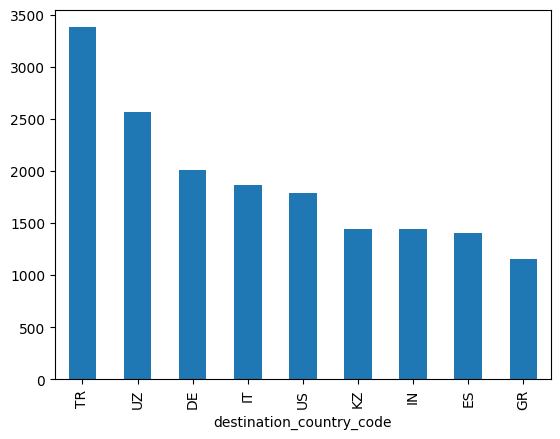

In [46]:
number_of_countries = 10
ax = df.destination_country_code.value_counts()[1:number_of_countries].plot.bar(rot = 90, log=False)

In [47]:
# country_mask = df.destination_country_code.isin(df.destination_country_code.value_counts()[:number_of_countries].index)
# df = df[country_mask]

In [48]:
df.nunique()

price                       17603
origin_city_code                5
number_of_changes               7
search_date                    26
destination_airport_code      967
depart_date                   327
diff_days                     330
search_weekday                  7
depart_weekday                  7
depart_month                   11
depart_day                     31
search_month                    3
search_day                     17
distance                     2824
airline                        10
airport_code                  967
destination_country_code      173
time_zone                     242
iata_type                       2
destination_airport_name      966
dtype: int64

In [50]:
df.drop_duplicates(inplace=True)

C:\Users\egora\AppData\Local\Temp\ipykernel_13396\3006716147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


In [51]:
df.to_json("data.json")